In [152]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread("foto1A.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("foto1B.jpg", cv2.IMREAD_GRAYSCALE)
largura_imagem, altura_imagem = img.shape
import imageio
import imutils

In [4]:
# import the necessary packages
import numpy as np
import imutils
import cv2
 
class Stitcher:
    def __init__(self):
        # determine if we are using OpenCV v3.X
        self.isv3 = imutils.is_cv3(or_better=True)
        
    def stitch(self, images, ratio=0.75, reprojThresh=4.0,
        showMatches=False):
        # unpack the images, then detect keypoints and extract
        # local invariant descriptors from them
        (imageB, imageA) = images
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)
        
        # match features between the two images
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)
 
        # if the match is None, then there aren't enough matched
        # keypoints to create a panorama
        if M is None:
            return None
        # otherwise, apply a perspective warp to stitch the images
        # together
        (matches, H, status) = M
        result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
 
        # check to see if the keypoint matches should be visualized
        if showMatches:
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches,status)
 
            # return a tuple of the stitched image and the
            # visualization
            return (result, vis)
 
        # return the stitched image
        return result
    
    def detectAndDescribe(self, image):
        # convert the image to grayscale
        gray = img.copy()

        # check to see if we are using OpenCV 3.X

        # detect keypoints in the image
        detector = cv2.FeatureDetector_create("SIFT")
        kps = detector.detect(gray)

        # extract features from the image
        extractor = cv2.DescriptorExtractor_create("SIFT")
        (kps, features) = extractor.compute(gray, kps)

        # convert the keypoints from KeyPoint objects to NumPy
        # arrays
        kps = np.float32([kp.pt for kp in kps])

        # return a tuple of keypoints and features
        return (kps, features)
    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB,
        ratio, reprojThresh):
        # compute the raw matches and initialize the list of actual
        # matches
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []

        # loop over the raw matches
        for m in rawMatches:
            # ensure the distance is within a certain ratio of each
            # other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,reprojThresh)

            # return the matches along with the homograpy matrix
            # and status of each matched point
            return (matches, H, status)

        # otherwise, no homograpy could be computed
        return None

    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # initialize the output visualization image
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        # loop over the matches
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # only process the match if the keypoint was successfully
            # matched
            if s == 1:
                # draw the match
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        # return the visualization
        return vis

[0.]


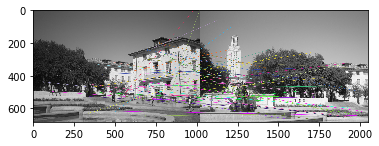

In [153]:
sift = cv2.xfeatures2d.SURF_create()
kp1,des1 = sift.detectAndCompute(img,None)
kp2,des2 = sift.detectAndCompute(img2,None)

bf = cv2.BFMatcher()
# Match descriptors.
matches = bf.knnMatch(des1,des2, k=2)
# Sort them in the order of their distance.
good = []
for m,n in matches:
    if m.distance < 0.3*n.distance:
        good.append([m])




# Draw first 10 matches.
out = np.zeros(1)
img3 = cv2.drawMatchesKnn(img2,kp2,img,kp1,good, out, flags=2)

print(out)



plt.imshow(img3),plt.show()
imageio.imwrite('saida.jpg', img3)

39


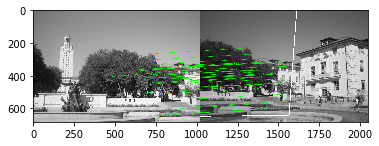

In [154]:
FLANN_INDEX_KDTREE = 0
SCH_PARAM_CHECKS = 50
INDEX_PARAM_TREES = 5

GOOD_MATCH_THRESHOLD = 0.2
MIN_MATCH_COUNT = 2

sift = cv2.xfeatures2d.SIFT_create()
kp1, desc1 = sift.detectAndCompute(img, None)
kp2, desc2 = sift.detectAndCompute(img2, None)

index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=INDEX_PARAM_TREES)
# number of times the trees in the index should be recursively traversed
# Higher values gives better precision, but also takes more time
sch_params = dict(checks=SCH_PARAM_CHECKS)
flann = cv2.FlannBasedMatcher(index_params, sch_params)

matches = flann.knnMatch(desc1, desc2, k=2)

# select good matches
matches_arr = []
good_matches = []
for m, n in matches:
    if m.distance < GOOD_MATCH_THRESHOLD * n.distance:
        good_matches.append(m)
    matches_arr.append(m)

if len(good_matches) < MIN_MATCH_COUNT:
    raise (Exception('Not enough matches found'))

src_pts = [kp1[m.queryIdx].pt for m in good_matches]
src_pts = np.array(src_pts, dtype=np.float32).reshape((-1, 1, 2))
dst_pts = [kp2[m.trainIdx].pt for m in good_matches]
dst_pts = np.array(dst_pts, dtype=np.float32).reshape((-1, 1, 2))



print (len(good_matches))




homo, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5)

result = cv2.warpPerspective(img, homo,(img.shape[1] + img2.shape[1], img.shape[0]))
img3 = visualize_homo(img,img2,kp1,kp2,good_matches, homo, mask)
#res = drawMatches(img, img2, kp1, kp2, matches, mask)

plt.imshow(img3),plt.show()
imageio.imwrite('saida.jpg', img3)


In [136]:
def visualize_homo(img1, img2, kp1, kp2, matches, homo, mask):
    h, w = img1.shape
    pts = [[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]
    pts = np.array(pts, dtype=np.float32).reshape((-1, 1, 2))
    dst = cv2.perspectiveTransform(pts, homo)

    img2 = cv2.polylines(img2, [np.int32(dst)], True, [255, 0, 0], 3, 8)

    matches_mask = mask.ravel().tolist()
    draw_params = dict(matchesMask=matches_mask,
                       singlePointColor=None,
                       matchColor=(0, 255, 0),
                       flags=2)
    res = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)
    return res